<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/09_pytorch_deploy_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ctrl c + ctrl v dos imports pardrao
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def create_effnetb2_model(out_features:int = 101,
                    seed:int=3):

  # Pesos, transforms, e instanciando o modelo
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #COngelando as camdas base
  for param in model.parameters():
    param.requires_grad=False

  #AJustando o classifier para o problema em questao
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=out_features))

  return model, transforms

In [4]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(out_features=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 154MB/s]


In [5]:
from torchinfo import summary

summary(effnetb2_food101,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [6]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
#Criando os tranforms para o treinamento
effnetb2_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])
effnetb2_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [8]:
#tranforms para teste
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Baixando os dados para o Big

In [9]:
from torchvision import datasets
from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=effnetb2_train_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

100%|██████████| 5.00G/5.00G [04:10<00:00, 19.9MB/s]


Extracting data/food-101.tar.gz to data


In [10]:
#NOme das classes
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Criando um subset do Food101

Para rodar experimentos mais rapido, o subset tera 20% dos dados do Food101.

**Objetivo:** Bater os 56.40% de precisao nos dados de teste, do paper original do Food101



In [11]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  print(f"[INFO] Dividindo o dataset de tamanho {len(dataset)} em porcoes de {length_1} e {length_2}")

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [12]:
train_data_food101_20_pct, _ = split_dataset(dataset=train_data,
                                             split_size=0.2)

test_data_food101_20_pct, _ = split_dataset(dataset=test_data,
                                            split_size=0.2)

[INFO] Dividindo o dataset de tamanho 75750 em porcoes de 15150 e 60600
[INFO] Dividindo o dataset de tamanho 25250 em porcoes de 5050 e 20200


In [13]:
len(train_data_food101_20_pct), len(test_data_food101_20_pct)

(15150, 5050)

##Transformando o dataset em DataLoaders

In [14]:
import os
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader_20_pct = torch.utils.data.DataLoader(dataset=train_data_food101_20_pct,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=NUM_WORKERS)

test_dataloader_20_pct = torch.utils.data.DataLoader(dataset=test_data_food101_20_pct,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     num_workers=NUM_WORKERS)

len(train_dataloader_20_pct),len(test_dataloader_20_pct)

(474, 158)

### Treino do Foodvision Big

Para o treino:
* 5 epochs
* Optimizer : `torch.optim.Adam(lr=1e-3)`
* Loss Function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Qual a ncessidade do label smoothing?
  * Se trata de uma tecnica de regularizacao, para efitar overfitting. Ex de uso:

Sem label_smoothing, com 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```
Com label_smoothing, com 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```






In [15]:
from going_modular.going_modular import engine

#otimizador
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

#Loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

#TReino
set_seeds()
effnetb2_food101_results =engine.train(model=effnetb2_food101,
                                       train_dataloader=train_dataloader_20_pct,
                                       test_dataloader=test_dataloader_20_pct,
                                       optimizer=optimizer,
                                       loss_fn = loss_fn,
                                       epochs=5,
                                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6402 | train_acc: 0.2778 | test_loss: 2.7788 | test_acc: 0.4862
Epoch: 2 | train_loss: 2.8600 | train_acc: 0.4422 | test_loss: 2.4729 | test_acc: 0.5322
Epoch: 3 | train_loss: 2.6542 | train_acc: 0.4879 | test_loss: 2.3633 | test_acc: 0.5562
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5092 | test_loss: 2.3037 | test_acc: 0.5715
Epoch: 5 | train_loss: 2.4962 | train_acc: 0.5228 | test_loss: 2.2799 | test_acc: 0.5776


## Loss curves do modelo

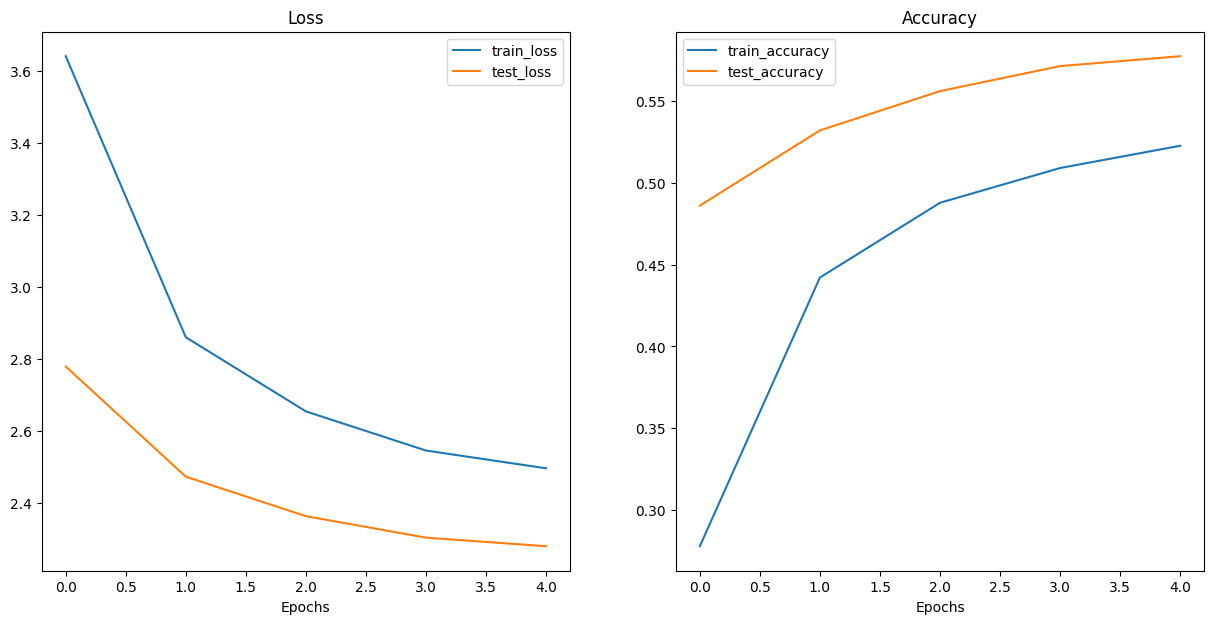

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

##Salvando o modelo

In [17]:
from going_modular.going_modular import utils

#CRiando o caminho para o modelo
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extrator_food101_20_percent.pth"

#Salvando
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extrator_food101_20_percent.pth


In [20]:
#Criando a instacia do moledo effentb2
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(out_features=101)

#Carreegando o state_dict do modelo
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extrator_food101_20_percent.pth"))

<ipython-input-20-b2891cf3bc51>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_ex

<All keys matched successfully>

Se der problema no app possivelmente esta aqui

## Checando o tamanho do modelo

In [22]:
from pathlib import Path

#COnvertendo o tamanho para mb
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Modelo de extracao de caracteristicas EffNetB2 pre-treinado com tamanho de {pretrained_effnetb2_food101_model_size} MB")

Modelo de extracao de caracteristicas EffNetB2 pre-treinado com tamanho de 30 MB


## Transformando o modelo do FoodVsion Big em um app

PQ? A melhor maneira de testar o modelo no mundo real

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```



In [23]:
#Criando o caminho para o big
foodvision_big_demo_path = Path("demos/foodvision_big/")

#CRaindo o diretorio do big
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

#Criando o diretorio de exemplos
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [27]:
!ls demos/foodvision_big/

examples


## Baixando imagens de exemplo e movendo ao diretorio

In [34]:
!wget https://github.com/HammadN98/pytorch/raw/main/dados/baklava_examples.jpg
!mv baklava_examples.jpg demos/foodvision_big/examples/baklava_examples.jpg

!wget https://github.com/HammadN98/pytorch/raw/main/dados/churros_examples.jpg
!mv churros_examples.jpg demos/foodvision_big/examples/churros_examples.jpg

!wget https://github.com/HammadN98/pytorch/raw/main/dados/pizza_example.jpg
!mv pizza_example.jpg demos/foodvision_big/examples/pizza_example.jpg

--2024-12-17 19:29:11--  https://github.com/HammadN98/pytorch/raw/main/dados/baklava_examples.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HammadN98/pytorch/main/dados/baklava_examples.jpg [following]
--2024-12-17 19:29:11--  https://raw.githubusercontent.com/HammadN98/pytorch/main/dados/baklava_examples.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54763 (53K) [image/jpeg]
Saving to: ‘baklava_examples.jpg’

baklava_examples.jp 100%[===================>]  53.48K  --.-KB/s    in 0.001s  

2024-12-17 19:29:11 (48.5 MB/s) - ‘baklava_examples.jpg’ saved [54763/54763]

--2024-12-17 1

In [35]:
!ls demos/foodvision_big/examples/

baklava_examples.jpg  churros_examples.jpg  pizza_example.jpg


In [36]:
!mv models/09_pretrained_effnetb2_feature_extrator_food101_20_percent.pth demos/foodvision_big/

## Salvando os nomes das classses do Food101 em um arquivo txt

class_names.txt

In [37]:
#Criando o caminho patra Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [38]:
#Escrevendo os nomes no arquivo
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Salvando o nomes das classes em {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Salvando o nomes das classes em demos/foodvision_big/class_names.txt


In [39]:
#Abrindo o arquivo p testar
with open(foodvision_big_class_names_path, "r") as f:
  foodvision_class_names_loaded = [food.strip() for food in f.readlines()]
foodvision_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## Transformando o modelo Foodvision Big em um Python script

* model.py

In [40]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int = 101,
                    seed:int=3):

  # Pesos, transforms, e instanciando o modelo
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #COngelando as camdas base
  for param in model.parameters():
    param.requires_grad=False

  #AJustando o classifier para o problema em questao
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes))

  return model, transforms

Writing demos/foodvision_big/model.py


Transformando o Gradio app em um script python
* app.py

O `app.py` tem 4 partes:

1. As importacoes e configuracoes de classes - Agora as classes serao importandas de um arquivo.txt
2. A preparacao do modelo e transforms
3. A funcao `predict()`
4. Gradio app - Interface Gradio + comando p rodar

In [41]:
%%writefile demos/foodvision_big/app.py
### importacoes
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

#coNFIGURANDO O NOME DAS CLASSES
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

## Modelo e Transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

#Carregando os pesos salvos
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extrator_food101_20_percent.pth",
               map_location=torch.device("cpu")) #load to cpu
)

###Funcao da predicao
def predict(img) -> Tuple[Dict, float]:

  #Comeca o time
  start_time = timer()

  #Transforma a imagem para o padrao EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) #unqueeze = add uma dimensao batch na posicao 0

  #Colocando o model em eval
  effnetb2.eval()
  with torch.inference_mode():

    #Pasando a imagem transformada pelo modelo de devolvendo os logist em pred prob
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Criando a label de predicao e o dicionario
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #Calculando o tempo de predicoa
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

## Gradio app
# Criando um titulo, descricao e artigo
title = "FoodVision Big"
description = "Um extartor de caracteristicas usando effnetb2 para classificar comidas apartir do Food101"
article = "Criando no modulo 09 do Bootcamp Pytorch by ZTM [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [["examples/" + examples] for examples in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)


demo.launch()

Writing demos/foodvision_big/app.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Importacoes
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, List

#Classes
class_names = ['pizza', 'steak', 'sushi']

### 2. MOdelo e transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_calsses=3)

#Carregando os pesos
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_vit_feature_extrator_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu")
    )
)

### 3. Funcao PRedict
def predict(img) -> Tuple[Dict, float]:

  #Comeca o time
  start_time = timer()

  #Transforma a imagem para o padrao EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) #unqueeze = add uma dimensao batch na posicao 0

  #Colocando o model em eval
  effnetb2.eval()
  with torch.inference_mode():

    #Pasando a imagem transformada pelo modelo de devolvendo os logist em pred prob
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Criando a label de predicao e o dicionario
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #Calculando o tempo de predicoa
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

### 4. GRadio

# Criando um titulo, descricao e artigo
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [["examples/" + examples] for examples in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)


demo.launch()